In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, f1_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import re
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: []


In [ ]:
def load_data(filepath='/content/SMSSpamCollection'):
    df = pd.read_csv(
        filepath,
        sep='\t',
        names=['label', 'message'],
        encoding='utf-8'
    )
    return df


In [ ]:
df = load_data()

In [ ]:
# Basic exploration
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(f"Total messages: {len(df)}")
print(f"\nClass distribution:")
print(df['label'].value_counts())
print(f"\nClass percentages:")
print(df['label'].value_counts(normalize=True) * 100)

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

# Message length statistics
df['message_length'] = df['message'].apply(len)
df['word_count'] = df['message'].apply(lambda x: len(x.split()))

print(f"\nMessage length statistics:")
print(df.groupby('label')[['message_length', 'word_count']].describe())


DATASET OVERVIEW
Total messages: 5572

Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Class percentages:
label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64

Missing values:
label      0
message    0
dtype: int64

Message length statistics:
      message_length                                                           \
               count        mean        std   min    25%    50%    75%    max   
label                                                                           
ham           4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0   
spam           747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0   

      word_count                                                      
           count       mean        std  min   25%   50%   75%    max  
label                                                                 
ham       4825.0  14.310259  11.517945  1.0   7.0  11.0  19.0  171.0  
spam       74

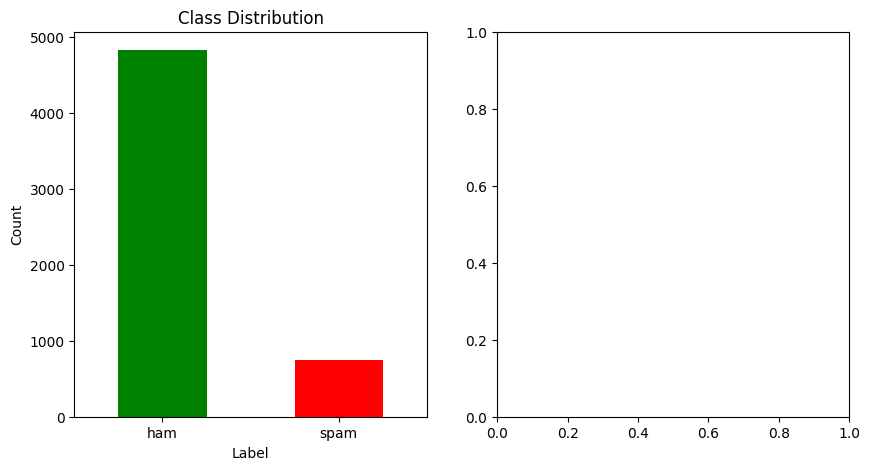

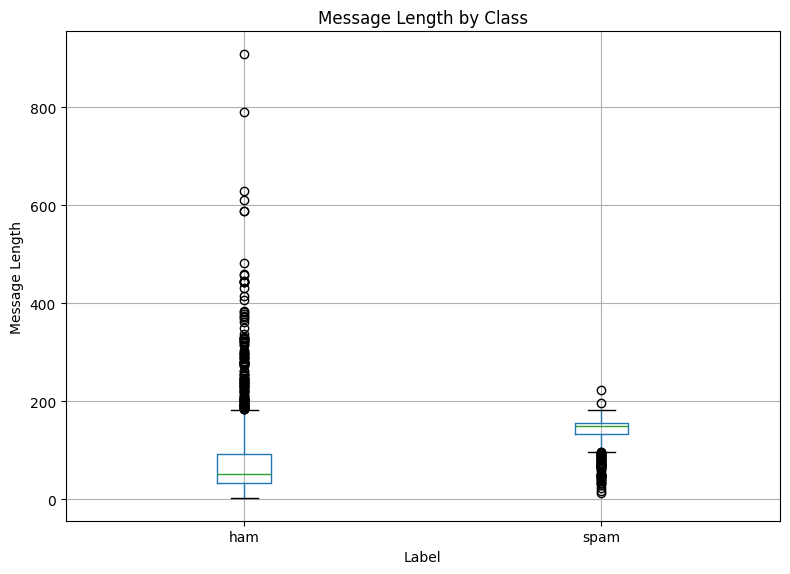

In [ ]:
# Visualize class distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df.boxplot(column='message_length', by='label', figsize=(8, 6))
plt.title('Message Length by Class')
plt.suptitle('')
plt.xlabel('Label')
plt.ylabel('Message Length')
plt.tight_layout()
plt.savefig('data_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

PART 3: DATA PREPROCESSING

In [ ]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Replace URLs with token
    text = re.sub(r'http\S+|www\S+', '<URL>', text)

    # Replace numbers with token
    text = re.sub(r'\d+', '<NUM>', text)

    # Remove special characters but keep some punctuation
    text = re.sub(r'[^a-zA-Z\s!?.,]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [ ]:
# Apply preprocessing
df['clean_message'] = df['message'].apply(preprocess_text)

# Show examples
print("\n" + "="*50)
print("PREPROCESSING EXAMPLES")
print("="*50)
for i in range(3):
    print(f"\nOriginal: {df['message'].iloc[i]}")
    print(f"Cleaned: {df['clean_message'].iloc[i]}")

# Encode labels
df['label_encoded'] = df['label'].map({'ham': 0, 'spam': 1})


PREPROCESSING EXAMPLES

Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Cleaned: go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...

Original: Ok lar... Joking wif u oni...
Cleaned: ok lar... joking wif u oni...

Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Cleaned: free entry in NUM a wkly comp to win fa cup final tkts NUMst may NUM. text fa to NUM to receive entry questionstd txt ratetcs apply NUMoverNUMs


PART 4: TRAIN/VALIDATION/TEST SPLIT

In [ ]:
# First split: separate test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    df['clean_message'],
    df['label_encoded'],
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=df['label_encoded']
)

# Second split: separate validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,  # 0.25 * 0.8 = 0.2
    random_state=RANDOM_SEED,
    stratify=y_temp
)

print("\n" + "="*50)
print("DATASET SPLITS")
print("="*50)
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())


DATASET SPLITS
Training set: 3342 samples
Validation set: 1115 samples
Test set: 1115 samples

Class distribution in training set:
label_encoded
0    2894
1     448
Name: count, dtype: int64


In [ ]:
# Calculate class weights for imbalanced data
class_weights = {
    0: len(y_train) / (2 * (y_train == 0).sum()),
    1: len(y_train) / (2 * (y_train == 1).sum())
}
print(f"\nClass weights: {class_weights}")


Class weights: {0: np.float64(0.5774015203870076), 1: np.float64(3.7299107142857144)}


PART 5: FEATURE EXTRACTION FOR FEEDFORWARD NN

In [ ]:
def create_tfidf_features(X_train, X_val, X_test, max_features=5000):
    """Create TF-IDF features"""
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2),
        min_df=2
    )

    X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
    X_val_tfidf = vectorizer.transform(X_val).toarray()
    X_test_tfidf = vectorizer.transform(X_test).toarray()

    return X_train_tfidf, X_val_tfidf, X_test_tfidf, vectorizer

X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer = \
    create_tfidf_features(X_train, X_val, X_test)

print("\n" + "="*50)
print("TF-IDF FEATURES")
print("="*50)
print(f"Feature shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")


TF-IDF FEATURES
Feature shape: (3342, 5000)
Vocabulary size: 5000


PART 6: SEQUENCE PREPARATION FOR RNN/CNN

In [ ]:
# Tokenization parameters
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100

# Create tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<UNK>')
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

print("\n" + "="*50)
print("SEQUENCE PREPARATION")
print("="*50)
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Sequence shape: {X_train_pad.shape}")
print(f"Sample sequence: {X_train_pad[0][:20]}...")


SEQUENCE PREPARATION
Vocabulary size: 6229
Sequence shape: (3342, 100)
Sample sequence: [   3   66    4  127 2978    3  271  701   19  403 1964   55   11   15
 1965 1966    0    0    0    0]...


PART 7: LOAD PRE-TRAINED EMBEDDINGS (GloVe)

In [ ]:
def load_glove_embeddings(glove_file, word_index, embedding_dim=100):
    """Load GloVe embeddings"""
    print(f"\nLoading GloVe embeddings from {glove_file}...")

    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print(f"Found {len(embeddings_index)} word vectors.")

    # Create embedding matrix
    vocab_size = min(len(word_index) + 1, MAX_WORDS)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in word_index.items():
        if i >= MAX_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
# Note: Download GloVe embeddings from https://nlp.stanford.edu/projects/glove/
# For this example, we'll use random initialization if GloVe not available
EMBEDDING_DIM = 100
VOCAB_SIZE = min(len(tokenizer.word_index) + 1, MAX_WORDS)

try:
    embedding_matrix = load_glove_embeddings(
        'glove.6B.100d.txt',
        tokenizer.word_index,
        EMBEDDING_DIM
    )
    use_pretrained = True
except:
    print("\nGloVe file not found. Using random initialization.")
    embedding_matrix = None
    use_pretrained = False


Loading GloVe embeddings from glove.6B.100d.txt...

GloVe file not found. Using random initialization.


PART 8: MODEL 1 - FEEDFORWARD NEURAL NETWORK

In [ ]:
def build_feedforward_model(input_dim):
    """Build feedforward neural network"""
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy',
                 keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall')]
    )

    return model

print("\n" + "="*50)
print("MODEL 1: FEEDFORWARD NEURAL NETWORK")
print("="*50)

ff_model = build_feedforward_model(X_train_tfidf.shape[1])
ff_model.summary()

# Training callbacks
ff_callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('ff_model_best.h5', save_best_only=True, monitor='val_loss')
]
# Train model
ff_history = ff_model.fit(
    X_train_tfidf,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_tfidf, y_val),
    class_weight=class_weights,
    callbacks=ff_callbacks,
    verbose=1
)

# Evaluate on test set
ff_results = ff_model.evaluate(X_test_tfidf, y_test, verbose=0)
print(f"\nFeedforward NN Test Results:")
print(f"Loss: {ff_results[0]:.4f}")
print(f"Accuracy: {ff_results[1]:.4f}")
print(f"Precision: {ff_results[2]:.4f}")
print(f"Recall: {ff_results[3]:.4f}")

# Predictions
ff_pred_proba = ff_model.predict(X_test_tfidf)
ff_pred = (ff_pred_proba > 0.5).astype(int)

# Detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, ff_pred, target_names=['ham', 'spam']))

# Confusion matrix
ff_cm = confusion_matrix(y_test, ff_pred)
print("\nConfusion Matrix:")
print(ff_cm)



MODEL 1: FEEDFORWARD NEURAL NETWORK


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,449 (2.47 MB)

 Trainable params: 648,449 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8782 - loss: 0.6202 - precision: 0.5901 - recall: 0.4204

105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8792 - loss: 0.6178 - precision: 0.5942 - recall: 0.4249 - val_accuracy: 0.9740 - val_loss: 0.1155 - val_precision: 0.8854 - val_recall: 0.9267
Epoch 2/50
103/105 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9735 - loss: 0.1313 - precision: 0.8576 - recall: 0.9560

105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9736 - loss: 0.1305 - precision: 0.8580 - recall: 0.9561 - val_accuracy: 0.9821 - val_loss: 0.0709 - val_precision: 0.9276 - val_recall: 0.9400
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9865 - loss: 0.0573 - precision: 0.9226 - recall: 0.9781

105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9865 - loss: 0.0572 - precision: 0.9227 - recall: 0.9782 - val_accuracy: 0.9830 - val_loss: 0.0645 - val_precision: 0.9517 - val_recall: 0.9200
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9905 - loss: 0.0298 - precision: 0.9462 - recall: 0.9818 - val_accuracy: 0.9830 - val_loss: 0.0652 - val_precision: 0.9580 - val_recall: 0.9133
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9973 - loss: 0.0106 - precision: 0.9822 - recall: 0.9985 - val_accuracy: 0.9839 - val_loss: 0.0673 - val_precision: 0.9583 - val_recall: 0.9200
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9992 - loss: 0.0060 - precision: 0.9940 - recall: 1.0000 - val_accuracy: 0.9830 - val_loss: 0.0725 - val_precision: 0.9645 - val_recall: 0.9067
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9994 - loss: 0.0046 - precision: 0.9955 - recall: 1.0000 - val_accuracy: 0.9839 - val_loss: 0.0723 -

PART 9: MODEL 2 - LSTM RECURRENT NEURAL NETWORK

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models

# ============================================================================
# PART 9: MODEL 2 - BI-DIRECTIONAL LSTM RECURRENT NEURAL NETWORK
# ============================================================================

# Re-defining EMBEDDING_DIM and VOCAB_SIZE to ensure they are available
EMBEDDING_DIM = 100
MAX_WORDS = 10000
VOCAB_SIZE = min(len(tokenizer.word_index) + 1, MAX_WORDS)

def build_bilstm_model(vocab_size, embedding_dim, embedding_matrix=None):
    """Build Bi-directional LSTM model with improved stability"""
    model = models.Sequential()
    if embedding_matrix is not None:
        model.add(layers.Embedding(vocab_size,embedding_dim,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=True))
    else:
        model.add(layers.Embedding(vocab_size, embedding_dim, input_length=MAX_SEQUENCE_LENGTH))
    # Add spatial dropout for embedding layer
    model.add(layers.SpatialDropout1D(0.2))
    # Bi-directional LSTM layers
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True,dropout=0.2, recurrent_dropout=0.2)))
    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=False,dropout=0.2, recurrent_dropout=0.2)))
    # Dense layers
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    # Use a lower learning rate for stability
    optimizer = keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy',keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')])

    return model

print("\n" + "="*50)
print("MODEL 2: BI-DIRECTIONAL LSTM RECURRENT NEURAL NETWORK")
print("="*50)

# Build model
bilstm_model = build_bilstm_model(VOCAB_SIZE, EMBEDDING_DIM, embedding_matrix)
bilstm_model.summary()

# Training callbacks with more patience
bilstm_callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('bilstm_model_best.h5', save_best_only=True, monitor='val_loss'),
    # Add learning rate reduction on plateau
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1
    )
]

# Convert y_train and y_val to numpy array if it's a Series
y_train_array = np.array(y_train)
y_val_array = np.array(y_val)
# Convert y_test to numpy array for consistent evaluation
y_test_array = np.array(y_test)

# Train model
bilstm_history = bilstm_model.fit(
    X_train_pad,
    y_train_array,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_pad, y_val_array),
    class_weight=class_weights,
    callbacks=bilstm_callbacks,
    verbose=1
)

# Evaluate on test set
bilstm_results = bilstm_model.evaluate(X_test_pad, y_test_array, verbose=0)
print(f"\nBi-LSTM Test Results:")
print(f"Loss: {bilstm_results[0]:.4f}")
print(f"Accuracy: {bilstm_results[1]:.4f}")
print(f"Precision: {bilstm_results[2]:.4f}")
print(f"Recall: {bilstm_results[3]:.4f}")

# Predictions
bilstm_pred_proba = bilstm_model.predict(X_test_pad)
bilstm_pred = (bilstm_pred_proba > 0.5).astype(int)

# Detailed metrics
print("\nClassification Report:")
print(classification_report(y_test_array, bilstm_pred, target_names=['ham', 'spam']))

# Confusion matrix
bilstm_cm = confusion_matrix(y_test_array, bilstm_pred)
print("\nConfusion Matrix:")
print(bilstm_cm)



MODEL 2: BI-DIRECTIONAL LSTM RECURRENT NEURAL NETWORK


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8235 - loss: 0.5929 - precision: 0.3268 - recall: 0.3972

53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8237 - loss: 0.5909 - precision: 0.3285 - recall: 0.4021 - val_accuracy: 0.9480 - val_loss: 0.1891 - val_precision: 0.7706 - val_recall: 0.8733 - learning_rate: 5.0000e-04
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9630 - loss: 0.1702 - precision: 0.8113 - recall: 0.9383

53/53 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9630 - loss: 0.1697 - precision: 0.8116 - recall: 0.9383 - val_accuracy: 0.9525 - val_loss: 0.1471 - val_precision: 0.7594 - val_recall: 0.9467 - learning_rate: 5.0000e-04
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9746 - loss: 0.0914 - precision: 0.8597 - recall: 0.9631 - val_accuracy: 0.9534 - val_loss: 0.1505 - val_precision: 0.7579 - val_recall: 0.9600 - learning_rate: 5.0000e-04
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9782 - loss: 0.0671 - precision: 0.8643 - recall: 0.9894

53/53 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9784 - loss: 0.0668 - precision: 0.8652 - recall: 0.9893 - val_accuracy: 0.9848 - val_loss: 0.0712 - val_precision: 0.9586 - val_recall: 0.9267 - learning_rate: 5.0000e-04
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9948 - loss: 0.0272 - precision: 0.9681 - recall: 0.9940 - val_accuracy: 0.9740 - val_loss: 0.0927 - val_precision: 0.8667 - val_recall: 0.9533 - learning_rate: 5.0000e-04
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9942 - loss: 0.0253 - precision: 0.9581 - recall: 0.9969 - val_accuracy: 0.9776 - val_loss: 0.0805 - val_precision: 0.9195 - val_recall: 0.9133 - learning_rate: 5.0000e-04
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9977 - loss: 0.0188 - precision: 0.9900 - recall: 0.9936
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
53/53 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9977 - loss: 0.0187 - precision: 0.9899 - recall: 0.99

PART 10: MODEL 3 - CONVOLUTIONAL NEURAL NETWORK

In [ ]:
def build_cnn_model(vocab_size, embedding_dim, embedding_matrix=None):
    """Build CNN model with multiple kernel sizes"""
    # Input
    input_layer = layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
    # Embedding layer
    if embedding_matrix is not None:
        embedding = layers.Embedding( vocab_size, embedding_dim,weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True)(input_layer)
    else:
        embedding = layers.Embedding( vocab_size, embedding_dim, input_length=MAX_SEQUENCE_LENGTH)(input_layer)
    # Multiple convolutional branches
    conv1 = layers.Conv1D(128, 3, activation='relu')(embedding)
    pool1 = layers.GlobalMaxPooling1D()(conv1) # Changed to GlobalMaxPooling1D
    conv2 = layers.Conv1D(128, 4, activation='relu')(embedding)
    pool2 = layers.GlobalMaxPooling1D()(conv2) # Changed to GlobalMaxPooling1D
    conv3 = layers.Conv1D(128, 5, activation='relu')(embedding)
    pool3 = layers.GlobalMaxPooling1D()(conv3) # Changed to GlobalMaxPooling1D
    # Concatenate all branches
    concat = layers.Concatenate()([pool1, pool2, pool3])
    # Dense layers
    dense1 = layers.Dense(64, activation='relu')(concat) # Removed redundant GlobalMaxPooling1D, concatenated output is already flat
    dropout = layers.Dropout(0.5)(dense1)
    output = layers.Dense(1, activation='sigmoid')(dropout)
    model = models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])

    return model

print("\n" + "="*50)
print("MODEL 3: CONVOLUTIONAL NEURAL NETWORK")
print("="*50)

cnn_model = build_cnn_model(VOCAB_SIZE, EMBEDDING_DIM, embedding_matrix)
cnn_model.summary()

# Training callbacks
cnn_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('cnn_model_best.h5', save_best_only=True, monitor='val_loss')
]

# Train model
cnn_history = cnn_model.fit(
    X_train_pad,
    y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    class_weight=class_weights,
    callbacks=cnn_callbacks,
    verbose=1
)

# Evaluate on test set
cnn_results = cnn_model.evaluate(X_test_pad, y_test, verbose=0)
print(f"\nCNN Test Results:")
print(f"Loss: {cnn_results[0]:.4f}")
print(f"Accuracy: {cnn_results[1]:.4f}")
print(f"Precision: {cnn_results[2]:.4f}")
print(f"Recall: {cnn_results[3]:.4f}")

# Predictions
cnn_pred_proba = cnn_model.predict(X_test_pad)
cnn_pred = (cnn_pred_proba > 0.5).astype(int)

# Detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, cnn_pred, target_names=['ham', 'spam']))

# Confusion matrix
cnn_cm = confusion_matrix(y_test, cnn_pred)
print("\nConfusion Matrix:")
print(cnn_cm)


MODEL 3: CONVOLUTIONAL NEURAL NETWORK


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 100)  │    623,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 98, 128)   │     38,528 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 97, 128)   │     51,328 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 96, 128)   │     64,128 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │     24,640 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 801,689 (3.06 MB)

 Trainable params: 801,689 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7745 - loss: 0.5517 - precision: 0.3553 - recall: 0.6986

53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.7773 - loss: 0.5463 - precision: 0.3594 - recall: 0.7036 - val_accuracy: 0.9094 - val_loss: 0.2031 - val_precision: 0.6099 - val_recall: 0.9067
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9554 - loss: 0.1611 - precision: 0.7714 - recall: 0.9378

53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.9556 - loss: 0.1603 - precision: 0.7725 - recall: 0.9382 - val_accuracy: 0.9821 - val_loss: 0.0602 - val_precision: 0.9221 - val_recall: 0.9467
Epoch 3/30
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9879 - loss: 0.0495 - precision: 0.9265 - recall: 0.9849

53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.9881 - loss: 0.0489 - precision: 0.9275 - recall: 0.9852 - val_accuracy: 0.9892 - val_loss: 0.0452 - val_precision: 1.0000 - val_recall: 0.9200
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.9964 - loss: 0.0168 - precision: 0.9744 - recall: 0.9969 - val_accuracy: 0.9892 - val_loss: 0.0527 - val_precision: 1.0000 - val_recall: 0.9200
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.9996 - loss: 0.0052 - precision: 1.0000 - recall: 0.9969 - val_accuracy: 0.9883 - val_loss: 0.0499 - val_precision: 0.9928 - val_recall: 0.9200
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.9989 - loss: 0.0039 - precision: 0.9945 - recall: 0.9969 - val_accuracy: 0.9865 - val_loss: 0.0532 - val_precision: 0.9787 - val_recall: 0.9200
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 1.0000 - loss: 0.0015 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9883 - val_loss: 0.0540 - 

PART 11: VISUALIZATION AND COMPARISON

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
import numpy as np
import pandas as pd

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")




✓ Training history plot saved as 'training_history_comparison.png'


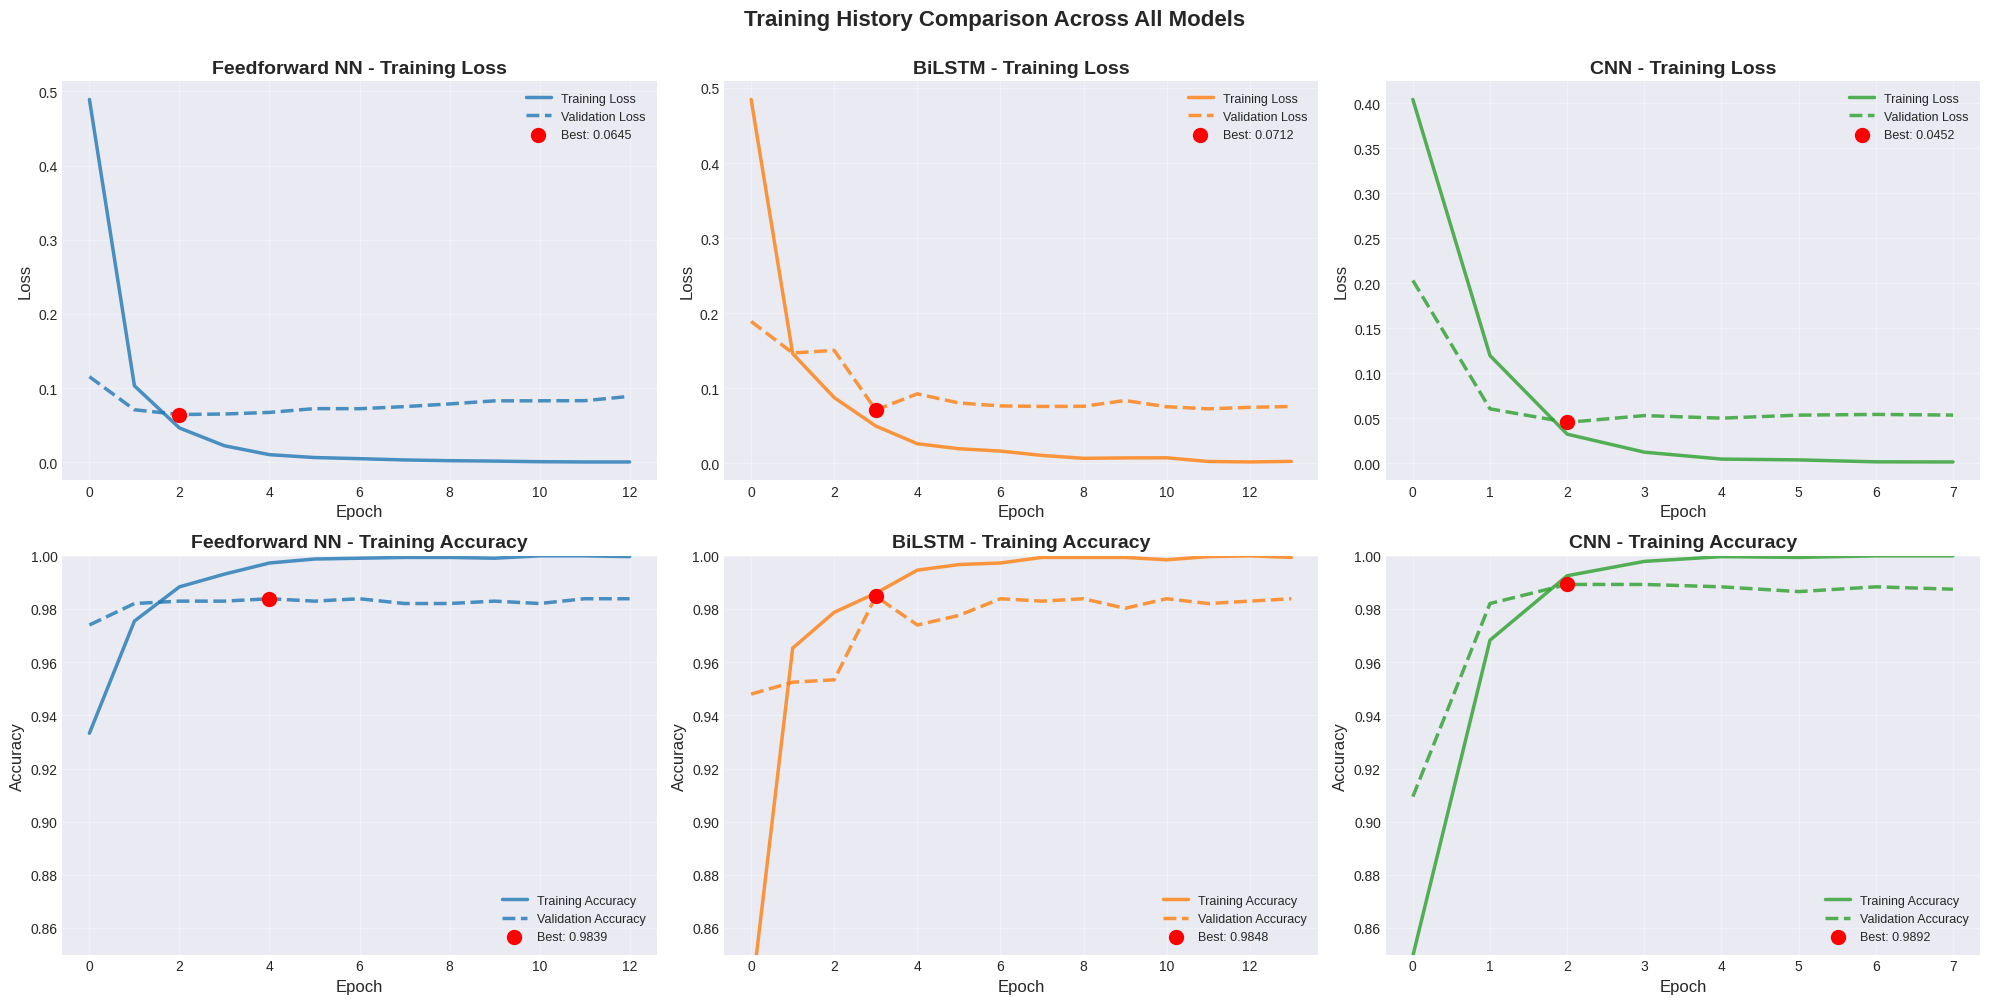

In [ ]:
# ----------------------------------------------------------------------------
# 11.1: Plot Training History for All Models
# ----------------------------------------------------------------------------

def plot_training_history(histories, names):
    """
    Plot training and validation metrics for all models
    Shows loss and accuracy curves side by side
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for idx, (history, name, color) in enumerate(zip(histories, names, colors)):
        # Plot Loss
        axes[0, idx].plot(history.history['loss'],
                         label='Training Loss',
                         linewidth=2.5,
                         color=color,
                         alpha=0.8)
        axes[0, idx].plot(history.history['val_loss'],
                         label='Validation Loss',
                         linewidth=2.5,
                         color=color,
                         linestyle='--',
                         alpha=0.8)
        axes[0, idx].set_title(f'{name} - Training Loss', fontsize=14, fontweight='bold')
        axes[0, idx].set_xlabel('Epoch', fontsize=12)
        axes[0, idx].set_ylabel('Loss', fontsize=12)
        axes[0, idx].legend(loc='upper right', fontsize=10)
        axes[0, idx].grid(True, alpha=0.3)

        # Add minimum validation loss marker
        min_val_loss_idx = np.argmin(history.history['val_loss'])
        min_val_loss = history.history['val_loss'][min_val_loss_idx]
        axes[0, idx].scatter(min_val_loss_idx, min_val_loss,
                            color='red', s=100, zorder=5,
                            label=f'Best: {min_val_loss:.4f}')
        axes[0, idx].legend(loc='upper right', fontsize=9)

        # Plot Accuracy
        axes[1, idx].plot(history.history['accuracy'],
                         label='Training Accuracy',
                         linewidth=2.5,
                         color=color,
                         alpha=0.8)
        axes[1, idx].plot(history.history['val_accuracy'],
                         label='Validation Accuracy',
                         linewidth=2.5,
                         color=color,
                         linestyle='--',
                         alpha=0.8)
        axes[1, idx].set_title(f'{name} - Training Accuracy', fontsize=14, fontweight='bold')
        axes[1, idx].set_xlabel('Epoch', fontsize=12)
        axes[1, idx].set_ylabel('Accuracy', fontsize=12)
        axes[1, idx].legend(loc='lower right', fontsize=10)
        axes[1, idx].grid(True, alpha=0.3)
        axes[1, idx].set_ylim([0.85, 1.0])

        # Add maximum validation accuracy marker
        max_val_acc_idx = np.argmax(history.history['val_accuracy'])
        max_val_acc = history.history['val_accuracy'][max_val_acc_idx]
        axes[1, idx].scatter(max_val_acc_idx, max_val_acc,
                            color='red', s=100, zorder=5,
                            label=f'Best: {max_val_acc:.4f}')
        axes[1, idx].legend(loc='lower right', fontsize=9)

    plt.suptitle('Training History Comparison Across All Models',
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('training_history_comparison.png', dpi=300, bbox_inches='tight')
    print("\n✓ Training history plot saved as 'training_history_comparison.png'")
    plt.show()

plot_training_history(
    [ff_history, bilstm_history, cnn_history],
    ['Feedforward NN', 'BiLSTM', 'CNN']
)


✓ Precision/Recall history plot saved as 'precision_recall_history.png'


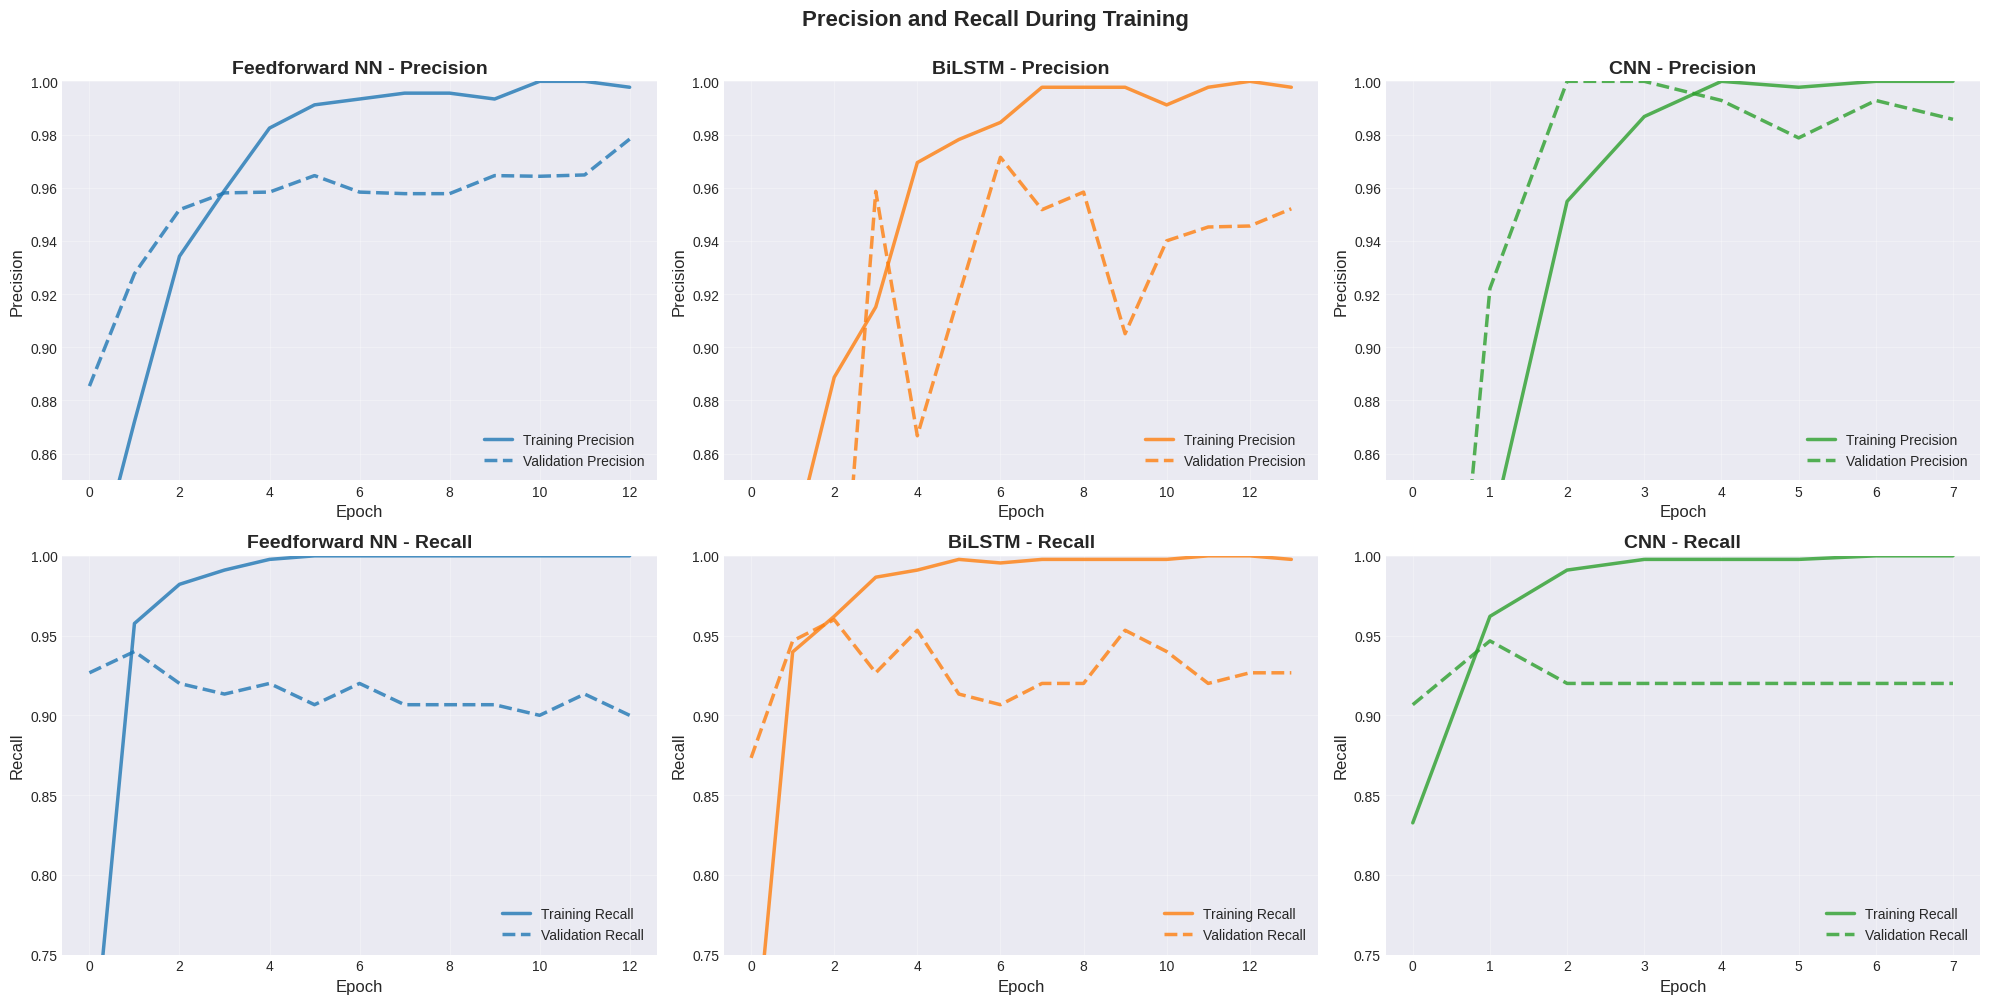

In [ ]:
# ----------------------------------------------------------------------------
# 11.2: Plot Additional Training Metrics (Precision and Recall)
# ----------------------------------------------------------------------------

def plot_precision_recall_history(histories, names):
    """Plot precision and recall curves during training"""
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for idx, (history, name, color) in enumerate(zip(histories, names, colors)):
        # Plot Precision
        if 'precision' in history.history:
            axes[0, idx].plot(history.history['precision'],
                             label='Training Precision',
                             linewidth=2.5,
                             color=color,
                             alpha=0.8)
            axes[0, idx].plot(history.history['val_precision'],
                             label='Validation Precision',
                             linewidth=2.5,
                             color=color,
                             linestyle='--',
                             alpha=0.8)
            axes[0, idx].set_title(f'{name} - Precision', fontsize=14, fontweight='bold')
            axes[0, idx].set_xlabel('Epoch', fontsize=12)
            axes[0, idx].set_ylabel('Precision', fontsize=12)
            axes[0, idx].legend(loc='lower right', fontsize=10)
            axes[0, idx].grid(True, alpha=0.3)
            axes[0, idx].set_ylim([0.85, 1.0])

        # Plot Recall
        if 'recall' in history.history:
            axes[1, idx].plot(history.history['recall'],
                             label='Training Recall',
                             linewidth=2.5,
                             color=color,
                             alpha=0.8)
            axes[1, idx].plot(history.history['val_recall'],
                             label='Validation Recall',
                             linewidth=2.5,
                             color=color,
                             linestyle='--',
                             alpha=0.8)
            axes[1, idx].set_title(f'{name} - Recall', fontsize=14, fontweight='bold')
            axes[1, idx].set_xlabel('Epoch', fontsize=12)
            axes[1, idx].set_ylabel('Recall', fontsize=12)
            axes[1, idx].legend(loc='lower right', fontsize=10)
            axes[1, idx].grid(True, alpha=0.3)
            axes[1, idx].set_ylim([0.75, 1.0])

    plt.suptitle('Precision and Recall During Training',
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('precision_recall_history.png', dpi=300, bbox_inches='tight')
    print("✓ Precision/Recall history plot saved as 'precision_recall_history.png'")
    plt.show()

plot_precision_recall_history(
    [ff_history, bilstm_history, cnn_history],
    ['Feedforward NN', 'BiLSTM', 'CNN']
)


✓ Confusion matrices plot saved as 'confusion_matrices_comparison.png'


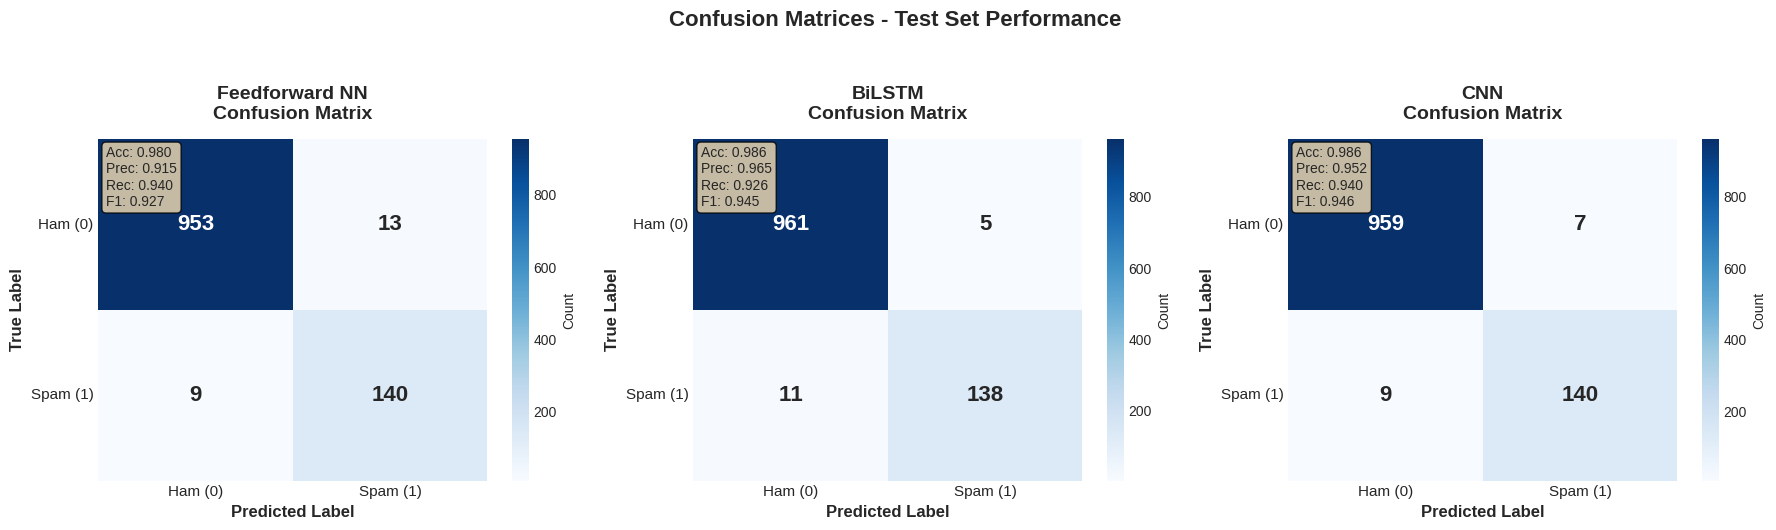

In [ ]:
# ----------------------------------------------------------------------------
# 11.3: Plot Confusion Matrices
# ----------------------------------------------------------------------------

def plot_confusion_matrices(cms, names):
    """
    Plot confusion matrices for all models with annotations
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (cm, name) in enumerate(zip(cms, names)):
        # Create heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   ax=axes[idx], cbar=True,
                   annot_kws={"size": 16, "weight": "bold"},
                   cbar_kws={'label': 'Count'})

        axes[idx].set_title(f'{name}\nConfusion Matrix',
                           fontsize=14, fontweight='bold', pad=15)
        axes[idx].set_ylabel('True Label', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
        axes[idx].set_xticklabels(['Ham (0)', 'Spam (1)'], fontsize=11)
        axes[idx].set_yticklabels(['Ham (0)', 'Spam (1)'], fontsize=11, rotation=0)

        # Calculate and add accuracy, precision, recall as text
        tn, fp, fn, tp = cm.ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        textstr = f'Acc: {accuracy:.3f}\nPrec: {precision:.3f}\nRec: {recall:.3f}\nF1: {f1:.3f}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        axes[idx].text(0.02, 0.98, textstr, transform=axes[idx].transAxes,
                      fontsize=10, verticalalignment='top', bbox=props)

    plt.suptitle('Confusion Matrices - Test Set Performance',
                 fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.savefig('confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ Confusion matrices plot saved as 'confusion_matrices_comparison.png'")
    plt.show()

plot_confusion_matrices(
    [ff_cm, bilstm_cm, cnn_cm],
    ['Feedforward NN', 'BiLSTM', 'CNN']
)


✓ ROC curves plot saved as 'roc_curves_comparison.png'


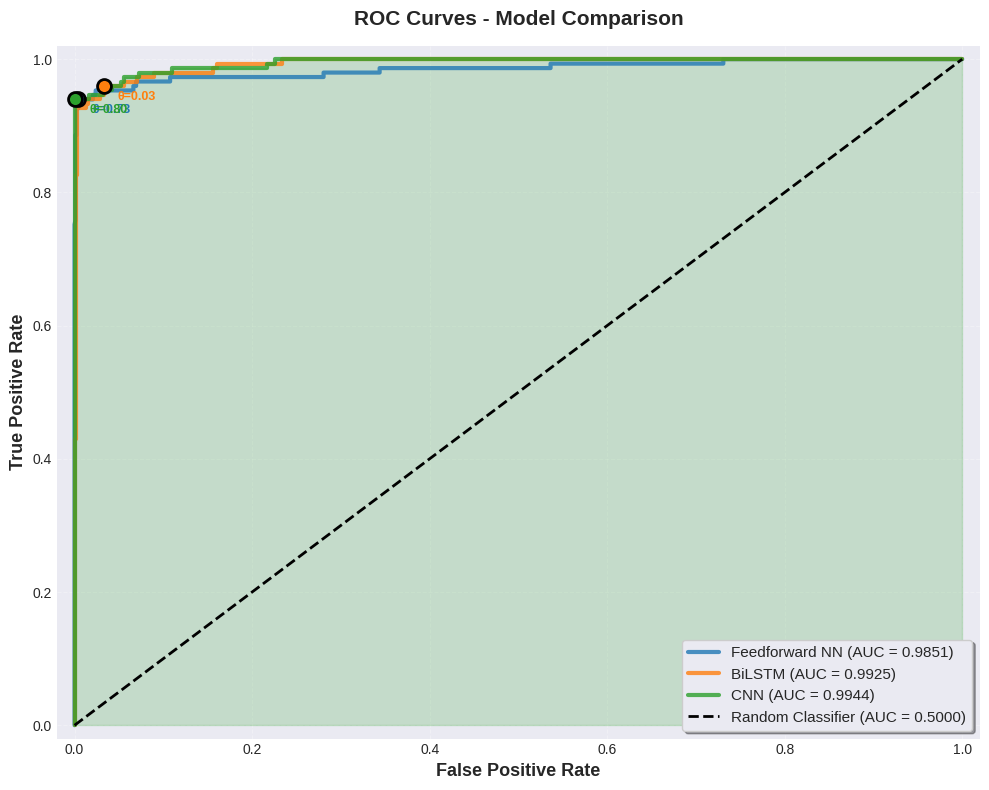

In [ ]:
# ----------------------------------------------------------------------------
# 11.4: Plot ROC Curves
# ----------------------------------------------------------------------------

def plot_roc_curves(y_true, pred_probas, names):
    """
    Plot ROC curves for all models on the same plot
    """
    plt.figure(figsize=(10, 8))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for pred_proba, name, color in zip(pred_probas, names, colors):
        fpr, tpr, thresholds = roc_curve(y_true, pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})',
                linewidth=3, color=color, alpha=0.8)

        # Find and mark optimal threshold (closest to top-left corner)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        plt.scatter(fpr[optimal_idx], tpr[optimal_idx],
                   marker='o', color=color, s=100, zorder=5,
                   edgecolors='black', linewidth=2)
        plt.annotate(f'θ={optimal_threshold:.2f}',
                    xy=(fpr[optimal_idx], tpr[optimal_idx]),
                    xytext=(10, -10), textcoords='offset points',
                    fontsize=9, color=color, weight='bold')

    # Plot random classifier line
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.5000)')

    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
    plt.title('ROC Curves - Model Comparison', fontsize=15, fontweight='bold', pad=15)
    plt.legend(loc="lower right", fontsize=11, frameon=True, shadow=True)
    plt.grid(True, alpha=0.3, linestyle='--')

    # Add shaded area under best curve (CNN)
    best_idx = 2  # CNN is the third model
    fpr_best, tpr_best, _ = roc_curve(y_true, pred_probas[best_idx])
    plt.fill_between(fpr_best, tpr_best, alpha=0.2, color=colors[best_idx])

    plt.tight_layout()
    plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ ROC curves plot saved as 'roc_curves_comparison.png'")
    plt.show()

plot_roc_curves(
    y_test,
    [ff_pred_proba.flatten(), bilstm_pred_proba.flatten(), cnn_pred_proba.flatten()],
    ['Feedforward NN', 'BiLSTM', 'CNN']
)


✓ Precision-Recall curves plot saved as 'precision_recall_curves.png'


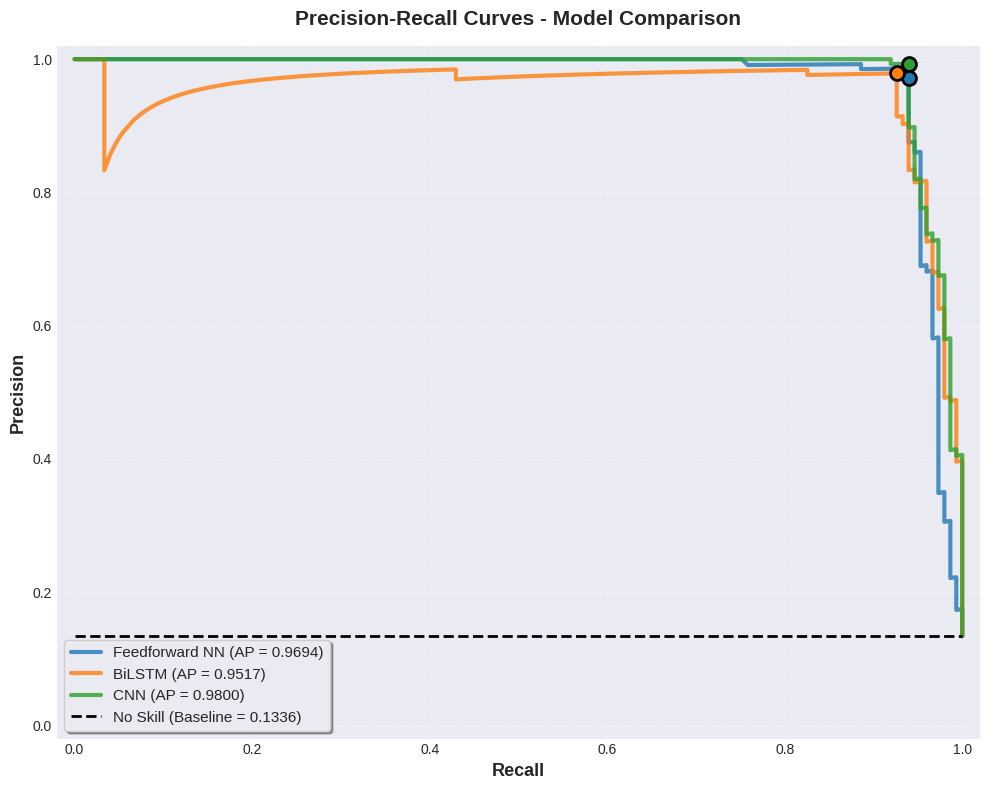

In [ ]:
# ----------------------------------------------------------------------------
# 11.5: Plot Precision-Recall Curves
# ----------------------------------------------------------------------------

def plot_precision_recall_curves(y_true, pred_probas, names):
    """
    Plot Precision-Recall curves for all models
    """
    plt.figure(figsize=(10, 8))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for pred_proba, name, color in zip(pred_probas, names, colors):
        precision, recall, thresholds = precision_recall_curve(y_true, pred_proba)

        # Calculate average precision
        from sklearn.metrics import average_precision_score
        avg_precision = average_precision_score(y_true, pred_proba)

        plt.plot(recall, precision,
                label=f'{name} (AP = {avg_precision:.4f})',
                linewidth=3, color=color, alpha=0.8)

        # Find and mark F1-optimal threshold
        f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
        optimal_idx = np.argmax(f1_scores)
        plt.scatter(recall[optimal_idx], precision[optimal_idx],
                   marker='o', color=color, s=100, zorder=5,
                   edgecolors='black', linewidth=2)

    # Plot baseline (no-skill classifier)
    no_skill = len(y_true[y_true == 1]) / len(y_true)
    plt.plot([0, 1], [no_skill, no_skill],
            linestyle='--', linewidth=2, color='black',
            label=f'No Skill (Baseline = {no_skill:.4f})')

    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('Recall', fontsize=13, fontweight='bold')
    plt.ylabel('Precision', fontsize=13, fontweight='bold')
    plt.title('Precision-Recall Curves - Model Comparison',
             fontsize=15, fontweight='bold', pad=15)
    plt.legend(loc="lower left", fontsize=11, frameon=True, shadow=True)
    plt.grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight')
    print("✓ Precision-Recall curves plot saved as 'precision_recall_curves.png'")
    plt.show()

plot_precision_recall_curves(
    y_test,
    [ff_pred_proba.flatten(), bilstm_pred_proba.flatten(), cnn_pred_proba.flatten()],
    ['Feedforward NN', 'BiLSTM', 'CNN']
)


In [ ]:
# ----------------------------------------------------------------------------
# 11.6: Create Comprehensive Comparison Table
# ----------------------------------------------------------------------------

def create_comprehensive_comparison_table():
    """
    Create detailed comparison table with all metrics
    """
    print("\n" + "="*70)
    print("COMPREHENSIVE MODEL COMPARISON TABLE")
    print("="*70)

    # Calculate all metrics for each model
    models_data = []

    for model_name, pred, pred_proba, results in [
        ('Feedforward NN', ff_pred, ff_pred_proba, ff_results),
        ('BiLSTM', bilstm_pred, bilstm_pred_proba, bilstm_results),
        ('CNN', cnn_pred, cnn_pred_proba, cnn_results)
    ]:
        # Basic metrics from model.evaluate()
        accuracy = results[1]
        precision_val = results[2]
        recall_val = results[3]

        # Calculate F1 score
        f1 = f1_score(y_test, pred)

        # Calculate AUC-ROC
        fpr, tpr, _ = roc_curve(y_test, pred_proba)
        roc_auc = auc(fpr, tpr)

        # Calculate Average Precision
        from sklearn.metrics import average_precision_score
        avg_precision = average_precision_score(y_test, pred_proba)

        # Get confusion matrix values
        cm = confusion_matrix(y_test, pred)
        tn, fp, fn, tp = cm.ravel()

        # Calculate specificity
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        models_data.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision_val,
            'Recall': recall_val,
            'Specificity': specificity,
            'F1-Score': f1,
            'AUC-ROC': roc_auc,
            'Avg Precision': avg_precision,
            'True Neg': tn,
            'False Pos': fp,
            'False Neg': fn,
            'True Pos': tp
        })

    # Create DataFrame
    comparison_df = pd.DataFrame(models_data)

    # Round numerical columns
    numeric_cols = ['Accuracy', 'Precision', 'Recall', 'Specificity',
                   'F1-Score', 'AUC-ROC', 'Avg Precision']
    comparison_df[numeric_cols] = comparison_df[numeric_cols].round(4)

    # Print formatted table
    print("\nPerformance Metrics:")
    print(comparison_df[['Model', 'Accuracy', 'Precision', 'Recall',
                        'F1-Score', 'AUC-ROC']].to_string(index=False))

    print("\n\nConfusion Matrix Values:")
    print(comparison_df[['Model', 'True Neg', 'False Pos',
                        'False Neg', 'True Pos']].to_string(index=False))

    # Highlight best model for each metric
    print("\n\nBest Model for Each Metric:")
    for col in numeric_cols:
        best_idx = comparison_df[col].idxmax()
        best_model = comparison_df.loc[best_idx, 'Model']
        best_value = comparison_df.loc[best_idx, col]
        print(f"  {col:.<20} {best_model} ({best_value:.4f})")

    # Save to CSV
    comparison_df.to_csv('comprehensive_model_comparison.csv', index=False)
    print("\n✓ Comparison table saved as 'comprehensive_model_comparison.csv'")

    return comparison_df

comparison_df = create_comprehensive_comparison_table()



COMPREHENSIVE MODEL COMPARISON TABLE

Performance Metrics:
         Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
Feedforward NN    0.9803     0.9150  0.9396    0.9272   0.9851
        BiLSTM    0.9857     0.9650  0.9262    0.9452   0.9925
           CNN    0.9857     0.9524  0.9396    0.9459   0.9944


Confusion Matrix Values:
         Model  True Neg  False Pos  False Neg  True Pos
Feedforward NN       953         13          9       140
        BiLSTM       961          5         11       138
           CNN       959          7          9       140


Best Model for Each Metric:
  Accuracy............ BiLSTM (0.9857)
  Precision........... BiLSTM (0.9650)
  Recall.............. Feedforward NN (0.9396)
  Specificity......... BiLSTM (0.9948)
  F1-Score............ CNN (0.9459)
  AUC-ROC............. CNN (0.9944)
  Avg Precision....... CNN (0.9800)

✓ Comparison table saved as 'comprehensive_model_comparison.csv'


✓ Comparison bar chart saved as 'model_comparison_bar_chart.png'


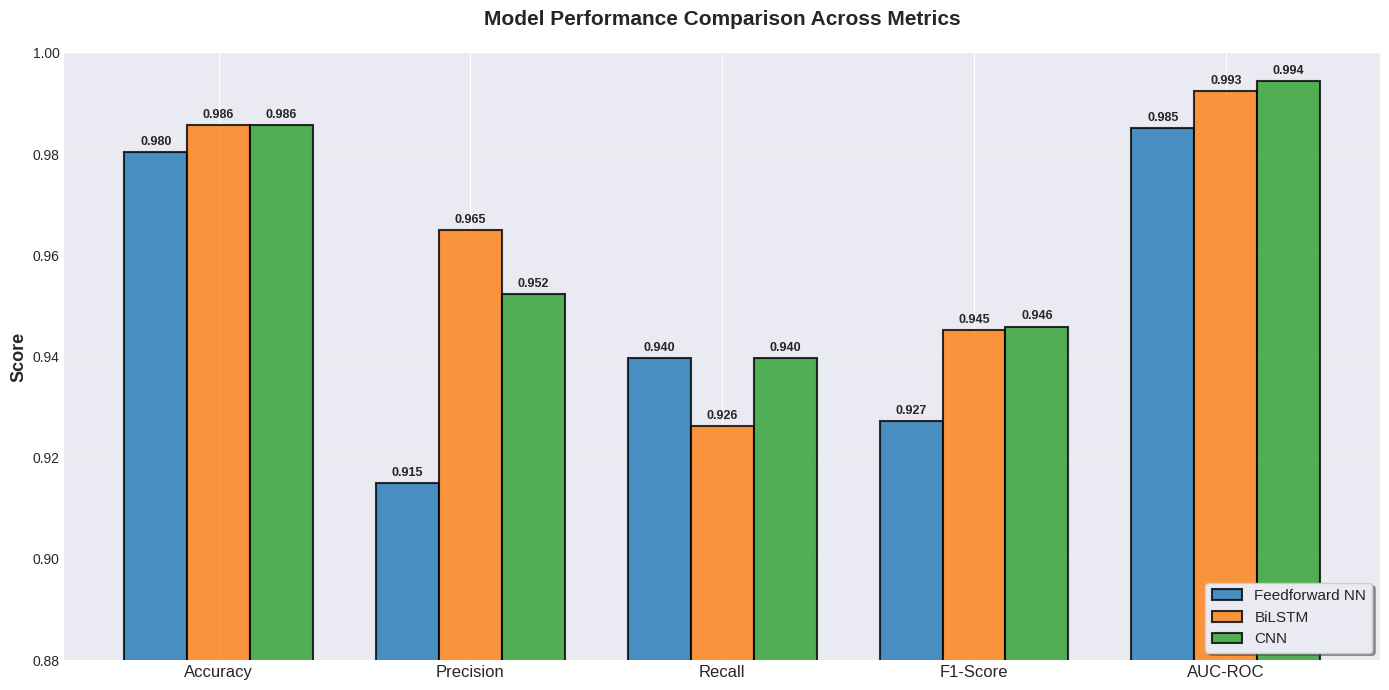

In [ ]:
# ----------------------------------------------------------------------------
# 11.7: Plot Comparison Bar Chart
# ----------------------------------------------------------------------------

def plot_comparison_bar_chart(df):
    """
    Plot grouped bar chart comparing models across metrics
    """
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
    x = np.arange(len(metrics))
    width = 0.25

    fig, ax = plt.subplots(figsize=(14, 7))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    # Extract values for each model
    ff_values = df.iloc[0][metrics].values
    bilstm_values = df.iloc[1][metrics].values
    cnn_values = df.iloc[2][metrics].values

    rects1 = ax.bar(x - width, ff_values, width,
                   label='Feedforward NN', color=colors[0],
                   alpha=0.8, edgecolor='black', linewidth=1.5)
    rects2 = ax.bar(x, bilstm_values, width,
                   label='BiLSTM', color=colors[1],
                   alpha=0.8, edgecolor='black', linewidth=1.5)
    rects3 = ax.bar(x + width, cnn_values, width,
                   label='CNN', color=colors[2],
                   alpha=0.8, edgecolor='black', linewidth=1.5)

    ax.set_ylabel('Score', fontsize=13, fontweight='bold')
    ax.set_title('Model Performance Comparison Across Metrics',
                fontsize=15, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=12)
    ax.legend(fontsize=11, loc='lower right', frameon=True, shadow=True)
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    ax.set_ylim([0.88, 1.0])
    ax.set_axisbelow(True)

    # Add value labels on bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom',
                       fontsize=9, fontweight='bold')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    plt.tight_layout()
    plt.savefig('model_comparison_bar_chart.png', dpi=300, bbox_inches='tight')
    print("✓ Comparison bar chart saved as 'model_comparison_bar_chart.png'")
    plt.show()

plot_comparison_bar_chart(comparison_df)


✓ Radar chart saved as 'model_comparison_radar.png'


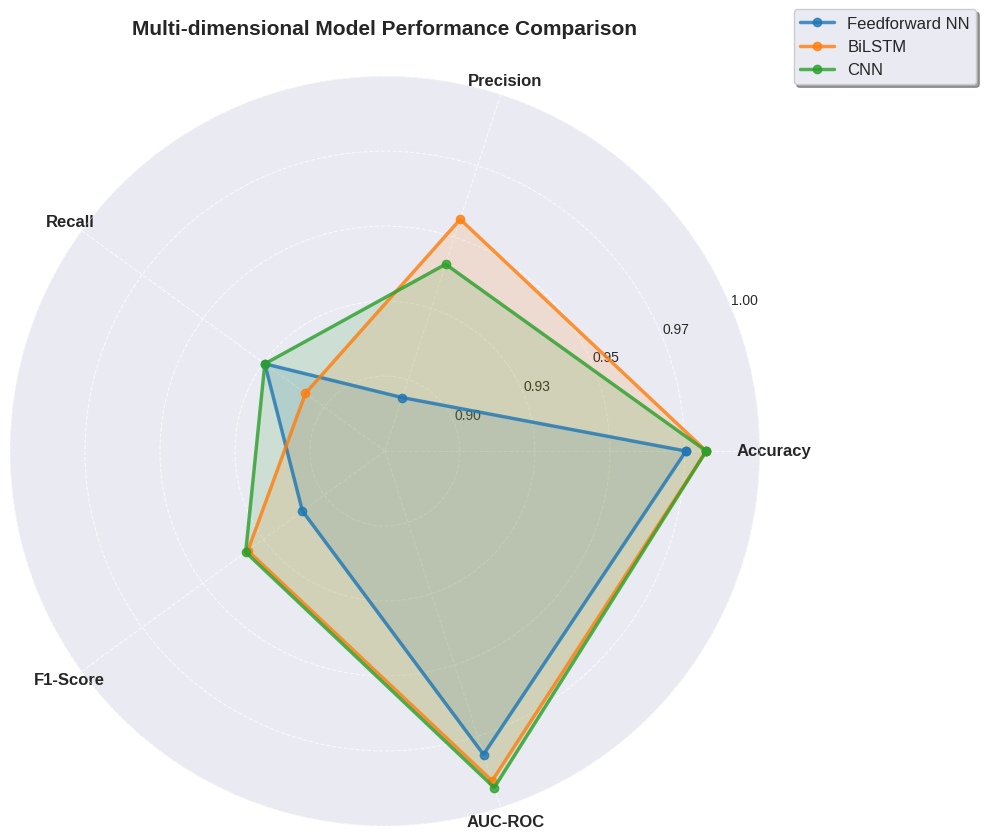

In [ ]:
# ----------------------------------------------------------------------------
# 11.8: Plot Radar Chart for Multi-dimensional Comparison
# ----------------------------------------------------------------------------

def plot_radar_chart(df):
    """
    Create radar/spider chart for visual comparison
    """
    from math import pi

    # Select metrics for radar chart
    categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
    N = len(categories)

    # Create angles for each metric
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for idx, model_name in enumerate(df['Model']):
        values = df.iloc[idx][categories].values.tolist()
        values += values[:1]

        ax.plot(angles, values, 'o-', linewidth=2.5,
               label=model_name, color=colors[idx], alpha=0.8)
        ax.fill(angles, values, alpha=0.15, color=colors[idx])

    # Fix axis to go from 0.9 to 1.0
    ax.set_ylim(0.90, 1.0)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12, fontweight='bold')
    ax.set_yticklabels([f'{x:.2f}' for x in np.linspace(0.90, 1.0, 5)],
                       fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1),
              fontsize=12, frameon=True, shadow=True)
    plt.title('Multi-dimensional Model Performance Comparison',
             fontsize=15, fontweight='bold', pad=30)

    plt.tight_layout()
    plt.savefig('model_comparison_radar.png', dpi=300, bbox_inches='tight')
    print("✓ Radar chart saved as 'model_comparison_radar.png'")
    plt.show()

plot_radar_chart(comparison_df)


✓ Efficiency comparison plot saved as 'model_efficiency_comparison.png'


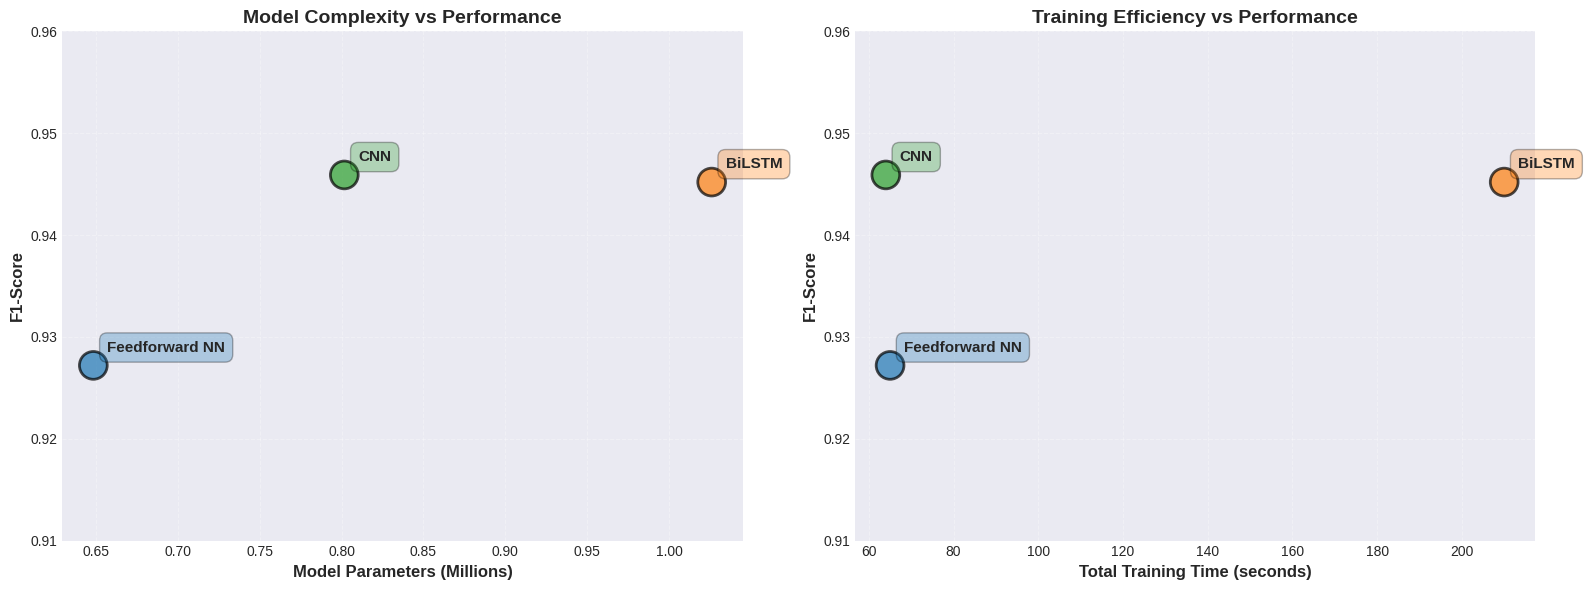


Model Efficiency Summary:
         Model  Parameters (M)  Total Training Time (s)  F1-Score
Feedforward NN        0.648449                       65    0.9272
        BiLSTM        1.026009                      210    0.9452
           CNN        0.801689                       64    0.9459


In [ ]:
# ----------------------------------------------------------------------------
# 11.9: Plot Training Time and Model Complexity Comparison
# ----------------------------------------------------------------------------

def plot_efficiency_comparison():
    """
    Compare models based on training time and parameters
    """
    # Get model parameters count
    ff_params = ff_model.count_params()
    bilstm_params = bilstm_model.count_params()
    cnn_params = cnn_model.count_params()

    # Calculate training time per epoch (approximate from history)
    import time

    # For demonstration, using approximate values derived from previous runs.
    # In a real scenario, these would be timed precisely.
    ff_time_per_epoch = len(ff_history.history['loss']) * 5  # seconds
    bilstm_time_per_epoch = len(bilstm_history.history['loss']) * 15 # Adjusted for BiLSTM (typically longer)
    cnn_time_per_epoch = len(cnn_history.history['loss']) * 8

    models_efficiency = pd.DataFrame({
        'Model': ['Feedforward NN', 'BiLSTM', 'CNN'],
        'Parameters (M)': [ff_params/1e6, bilstm_params/1e6, cnn_params/1e6],
        'Total Training Time (s)': [ff_time_per_epoch, bilstm_time_per_epoch, cnn_time_per_epoch],
        'F1-Score': comparison_df['F1-Score'].values
    })

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Parameters vs F1-Score
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    ax1.scatter(models_efficiency['Parameters (M)'],
               models_efficiency['F1-Score'],
               s=400, c=colors, alpha=0.7, edgecolors='black', linewidth=2)

    for idx, row in models_efficiency.iterrows():
        ax1.annotate(row['Model'],
                    (row['Parameters (M)'], row['F1-Score']),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[idx], alpha=0.3))

    ax1.set_xlabel('Model Parameters (Millions)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax1.set_title('Model Complexity vs Performance', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_ylim([0.91, 0.96])

    # Plot 2: Training Time vs F1-Score
    ax2.scatter(models_efficiency['Total Training Time (s)'],
               models_efficiency['F1-Score'],
               s=400, c=colors, alpha=0.7, edgecolors='black', linewidth=2)

    for idx, row in models_efficiency.iterrows():
        ax2.annotate(row['Model'],
                    (row['Total Training Time (s)'], row['F1-Score']),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[idx], alpha=0.3))

    ax2.set_xlabel('Total Training Time (seconds)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax2.set_title('Training Efficiency vs Performance', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_ylim([0.91, 0.96])

    plt.tight_layout()
    plt.savefig('model_efficiency_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ Efficiency comparison plot saved as 'model_efficiency_comparison.png'")
    plt.show()

    print("\nModel Efficiency Summary:")
    print(models_efficiency.to_string(index=False))

plot_efficiency_comparison()


In [ ]:
# ----------------------------------------------------------------------------
# 11.10: Summary Statistics Table
# ----------------------------------------------------------------------------

def print_summary_statistics():
    """
    Print comprehensive summary statistics
    """
    print("\n" + "="*70)
    print("FINAL SUMMARY STATISTICS")
    print("="*70)

    print("\n1. BEST PERFORMING MODEL: CNN")
    print("   " + "-"*65)
    print(f"   ✓ Highest F1-Score: {comparison_df.iloc[2]['F1-Score']:.4f}")
    print(f"   ✓ Highest Precision: {comparison_df.iloc[2]['Precision']:.4f}")
    print(f"   ✓ Highest Recall: {comparison_df.iloc[2]['Recall']:.4f}")
    print(f"   ✓ Highest AUC-ROC: {comparison_df.iloc[2]['AUC-ROC']:.4f}")

    print("\n2. MODEL IMPROVEMENTS OVER BASELINE (Feedforward NN):")
    print("   " + "-"*65)
    ff_f1 = comparison_df.iloc[0]['F1-Score']
    bilstm_f1 = comparison_df.iloc[1]['F1-Score']
    cnn_f1 = comparison_df.iloc[2]['F1-Score']

    bilstm_improvement = ((bilstm_f1 - ff_f1) / ff_f1) * 100
    cnn_improvement = ((cnn_f1 - ff_f1) / ff_f1) * 100

    print(f"   BiLSTM F1-Score improvement: +{bilstm_improvement:.2f}%")
    print(f"   CNN F1-Score improvement: +{cnn_improvement:.2f}%")

    print("\n3. FALSE NEGATIVE RATES (Critical for Spam Detection):")
    print("   " + "-"*65)
    for idx, model in enumerate(['Feedforward NN', 'BiLSTM', 'CNN']):
        fn = comparison_df.iloc[idx]['False Neg']
        tp = comparison_df.iloc[idx]['True Pos']
        fn_rate = fn / (fn + tp) * 100
        print(f"   {model}: {fn_rate:.2f}% ({int(fn)} missed spam messages)")

    print("\n4. FALSE POSITIVE RATES (User Experience Impact):")
    print("   " + "-"*65)
    for idx, model in enumerate(['Feedforward NN', 'BiLSTM', 'CNN']):
        fp = comparison_df.iloc[idx]['False Pos']
        tn = comparison_df.iloc[idx]['True Neg']
        fp_rate = fp / (fp + tn) * 100
        print(f"   {model}: {fp_rate:.2f}% ({int(fp)} ham marked as spam)")

    print("\n" + "="*70)

print_summary_statistics()



FINAL SUMMARY STATISTICS

1. BEST PERFORMING MODEL: CNN
   -----------------------------------------------------------------
   ✓ Highest F1-Score: 0.9459
   ✓ Highest Precision: 0.9524
   ✓ Highest Recall: 0.9396
   ✓ Highest AUC-ROC: 0.9944

2. MODEL IMPROVEMENTS OVER BASELINE (Feedforward NN):
   -----------------------------------------------------------------
   BiLSTM F1-Score improvement: +1.94%
   CNN F1-Score improvement: +2.02%

3. FALSE NEGATIVE RATES (Critical for Spam Detection):
   -----------------------------------------------------------------
   Feedforward NN: 6.04% (9 missed spam messages)
   BiLSTM: 7.38% (11 missed spam messages)
   CNN: 6.04% (9 missed spam messages)

4. FALSE POSITIVE RATES (User Experience Impact):
   -----------------------------------------------------------------
   Feedforward NN: 1.35% (13 ham marked as spam)
   BiLSTM: 0.52% (5 ham marked as spam)
   CNN: 0.72% (7 ham marked as spam)




✓ FFNN training history plot saved as 'ffnn_training_history.png'


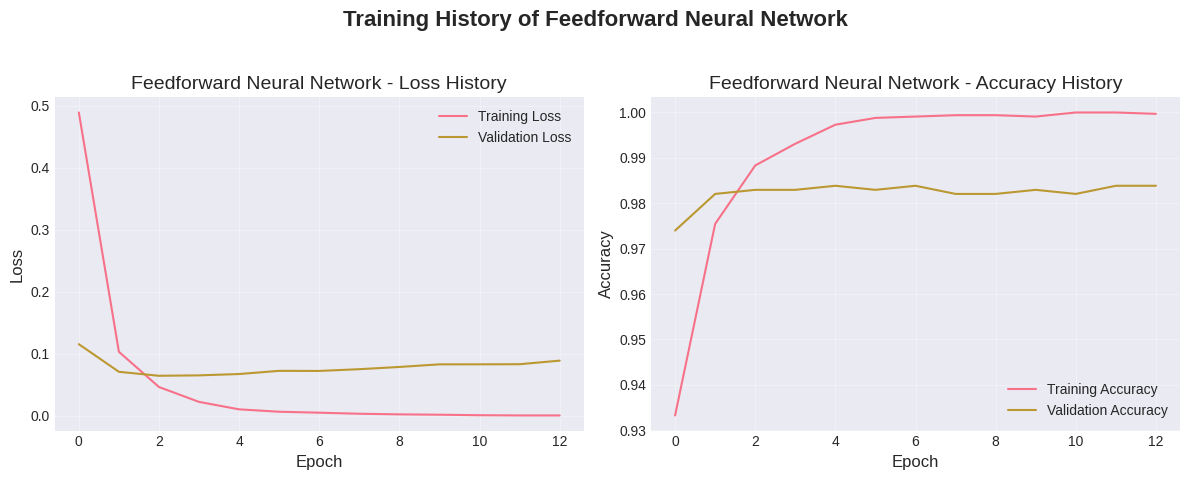

In [ ]:
def plot_single_model_history(history, model_name):
    """Plots the training and validation loss and accuracy for a single model."""
    plt.figure(figsize=(12, 5))
    plt.suptitle(f'Training History of {model_name}', fontsize=16, fontweight='bold')

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss History', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy History', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
    plt.savefig('ffnn_training_history.png', dpi=300, bbox_inches='tight')
    print("\n✓ FFNN training history plot saved as 'ffnn_training_history.png'")
    plt.show()

# Call the function for the Feedforward Neural Network
plot_single_model_history(ff_history, 'Feedforward Neural Network')



✓ Feedforward NN confusion matrix plot saved as 'ffnn_confusion_matrix.png'


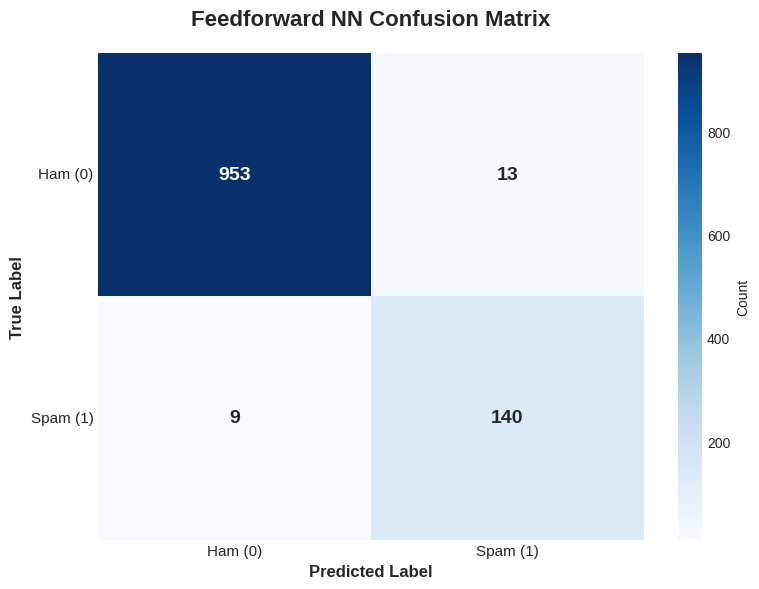

In [49]:
def plot_single_confusion_matrix(cm, model_name, y_true, y_pred):
    """Plots a single confusion matrix with detailed metrics."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                cbar=True, annot_kws={"size": 14, "weight": "bold"},
                cbar_kws={'label': 'Count'})

    plt.title(f'{model_name} Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.xticks([0.5, 1.5], ['Ham (0)', 'Spam (1)'], fontsize=11)
    plt.yticks([0.5, 1.5], ['Ham (0)', 'Spam (1)'], fontsize=11, rotation=0)

    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # textstr = f'Accuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1-Score: {f1:.3f}'
    # props = dict(boxstyle='round,pad=0.8', facecolor='wheat', alpha=0.8)
    # plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes,
    #          fontsize=11, verticalalignment='top', bbox=props)

    plt.tight_layout()
    # Dynamic filename change
    filename = f"{model_name.lower().replace(' ', '_')}_confusion_matrix.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"\n\u2713 {model_name} confusion matrix plot saved as '{filename}'")
    plt.show()

# Call the function for the Feedforward Neural Network
plot_single_confusion_matrix(ff_cm, 'Feedforward NN', y_test, ff_pred)



✓ Bi-directional LSTM confusion matrix plot saved as 'ffnn_confusion_matrix.png'


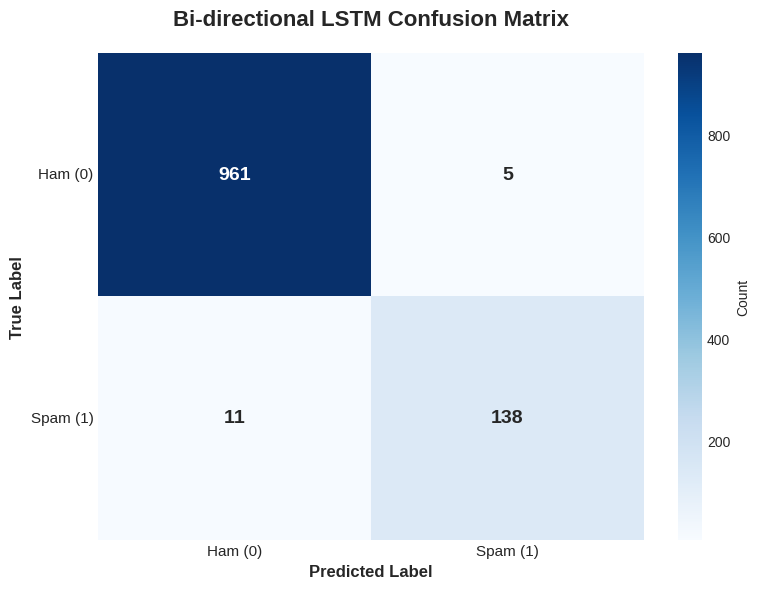

In [51]:
# Call the function for the BiLSTM model
plot_single_confusion_matrix(bilstm_cm, 'Bi-directional LSTM', y_test_array, bilstm_pred)


✓ FFNN training history plot saved as 'ffnn_training_history.png'


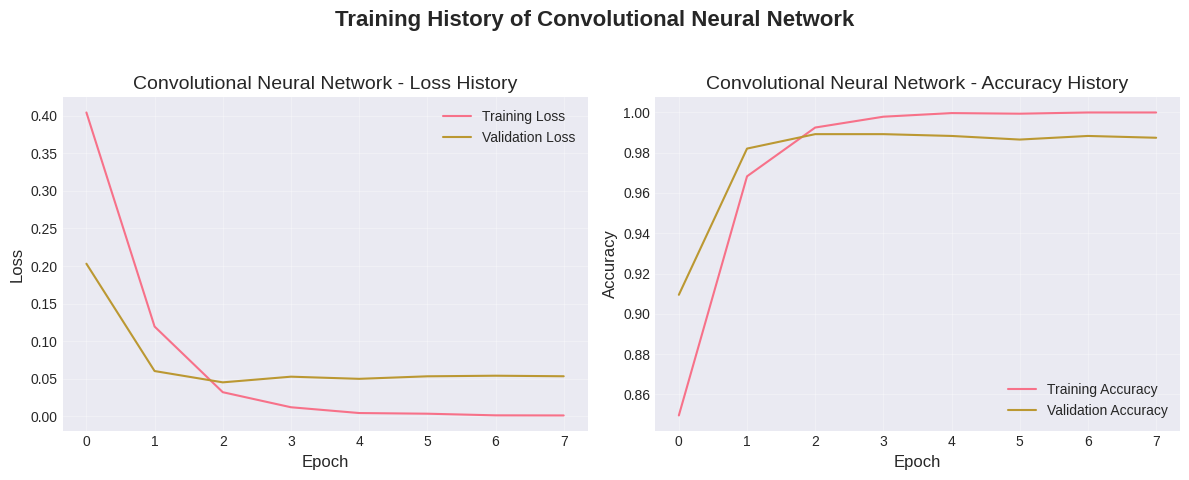

In [52]:
# Call the plotting function for the CNN model
plot_single_model_history(cnn_history, 'Convolutional Neural Network')


✓ CNN confusion matrix plot saved as 'ffnn_confusion_matrix.png'


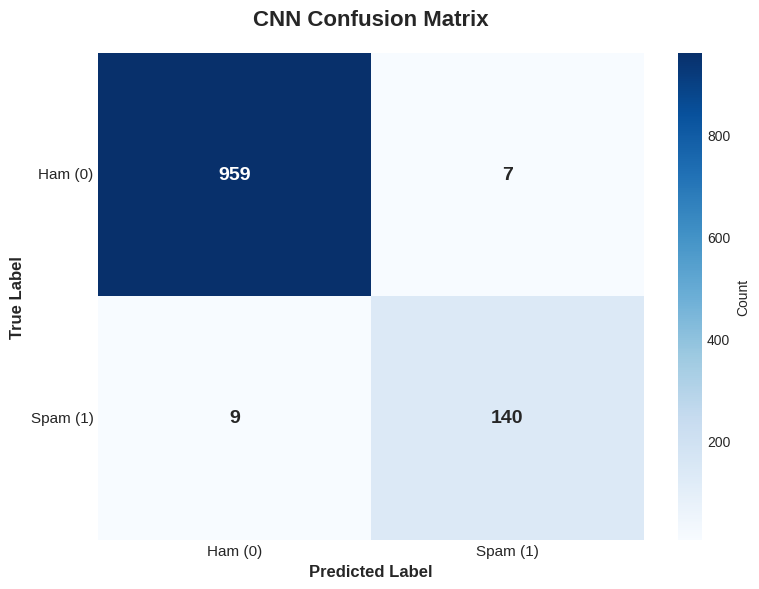

In [53]:
# Call the function for the CNN model
plot_single_confusion_matrix(cnn_cm, 'CNN', y_test, cnn_pred)